## Introduction
At the end of the [previous post](https://cgcooke.github.io/Blog/computer%20vision/blender/2020/10/23/Synthetic-Training-Data-With-Blender.html), I had shown how to use *Blender* to generate depth maps and semantic segmentation maps.

However, this information is in [OpenEXR](https://en.wikipedia.org/wiki/OpenEXR) format, and we need to transform it to a form more suitable for training a computer vision model.

While writing this post, I found [this](http://www.tobias-weis.de/groundtruth-data-for-computer-vision-with-blender/) post by *Tobias Weis* to be beneficial.


In [1]:
import OpenEXR
import Imath
from PIL import Image
import array
import numpy as np
import json

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams['figure.figsize'] = [20,20]

### Extracting numpy array

Next, we can use some "boilerplate" code to convert the exr file into a Numpy array.

In [2]:
def exr2numpy(exr_path, chanel_name):
    '''
    See:
    https://excamera.com/articles/26/doc/intro.html
    http://www.tobias-weis.de/groundtruth-data-for-computer-vision-with-blender/
    '''
    file = OpenEXR.InputFile(exr_path)
    dw = file.header()['dataWindow']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)
    
    Float_Type = Imath.PixelType(Imath.PixelType.FLOAT)
    
    channel_str = file.channel(chanel_name, Float_Type)
    
    channel = np.fromstring(channel_str, dtype = np.float32).reshape(size[1],-1)
    
    return(channel)

### Semantic Index

<ipython-input-2-06585295a370>:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  channel = np.fromstring(channel_str, dtype = np.float32).reshape(size[1],-1)


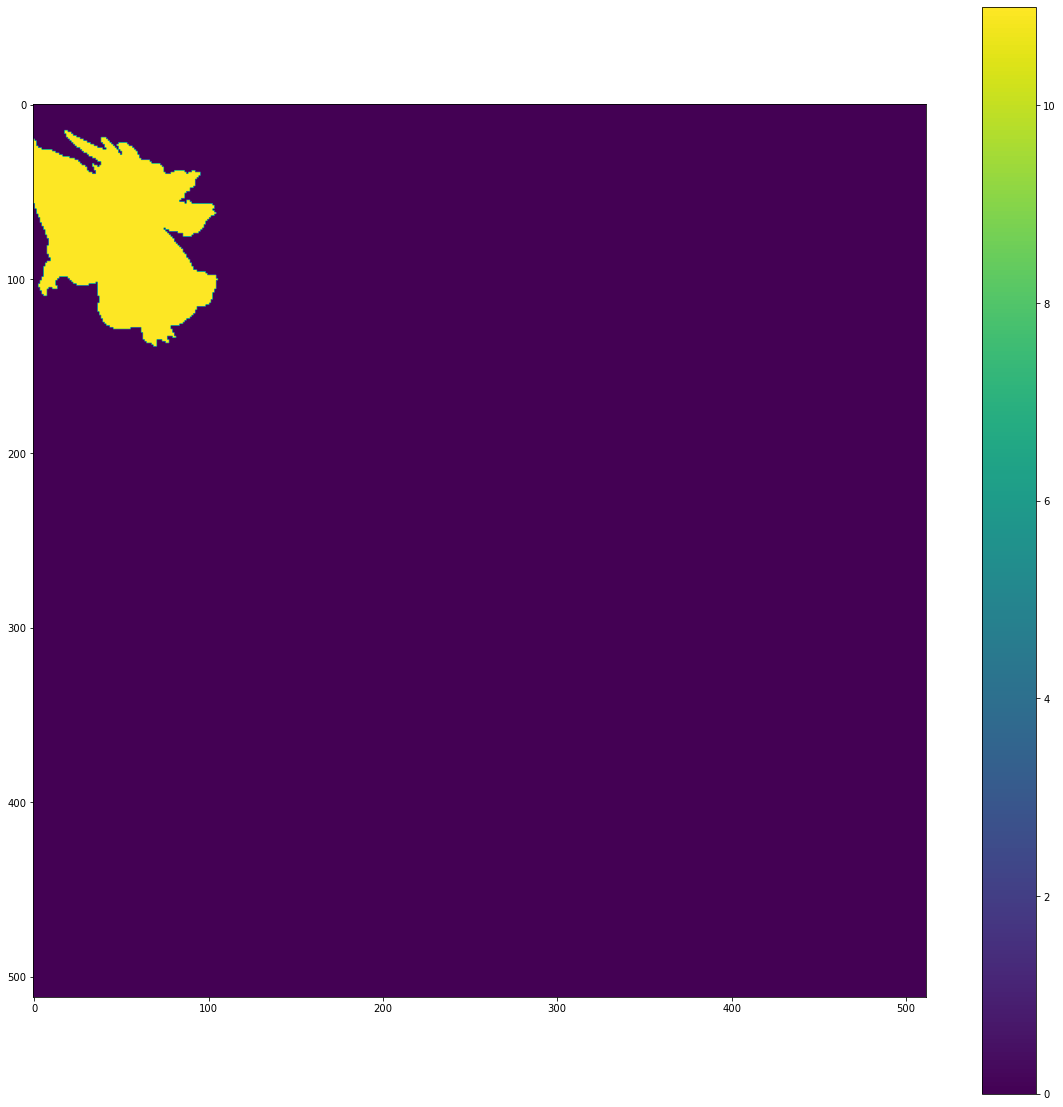

In [3]:
exr_path = "Data/2020-10-30-Training-Data-From-OpenEXR/Index/Image0001.exr"
semantic_index = exr2numpy(exr_path, chanel_name= 'R')
fig = plt.figure()
plt.imshow(semantic_index)
plt.colorbar()
plt.show()

### Depth (Meters)

<ipython-input-2-06585295a370>:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  channel = np.fromstring(channel_str, dtype = np.float32).reshape(size[1],-1)


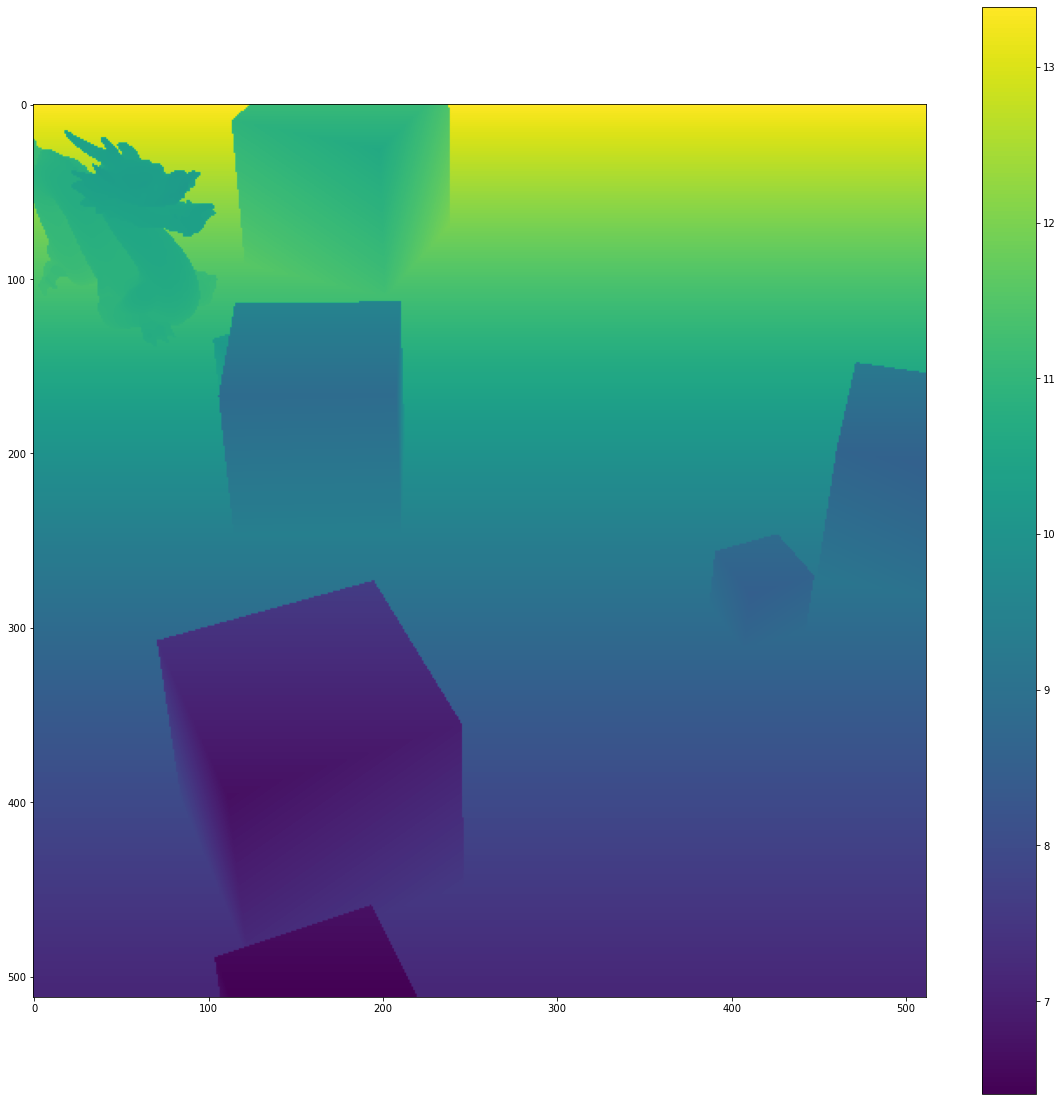

In [4]:
exr_path = "Data/2020-10-30-Training-Data-From-OpenEXR/Depth/Image0001.exr"
depth = exr2numpy(exr_path, chanel_name= 'R')
fig = plt.figure()
plt.imshow(depth)
plt.colorbar()
plt.show()

### RGB Image

<ipython-input-2-06585295a370>:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  channel = np.fromstring(channel_str, dtype = np.float32).reshape(size[1],-1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


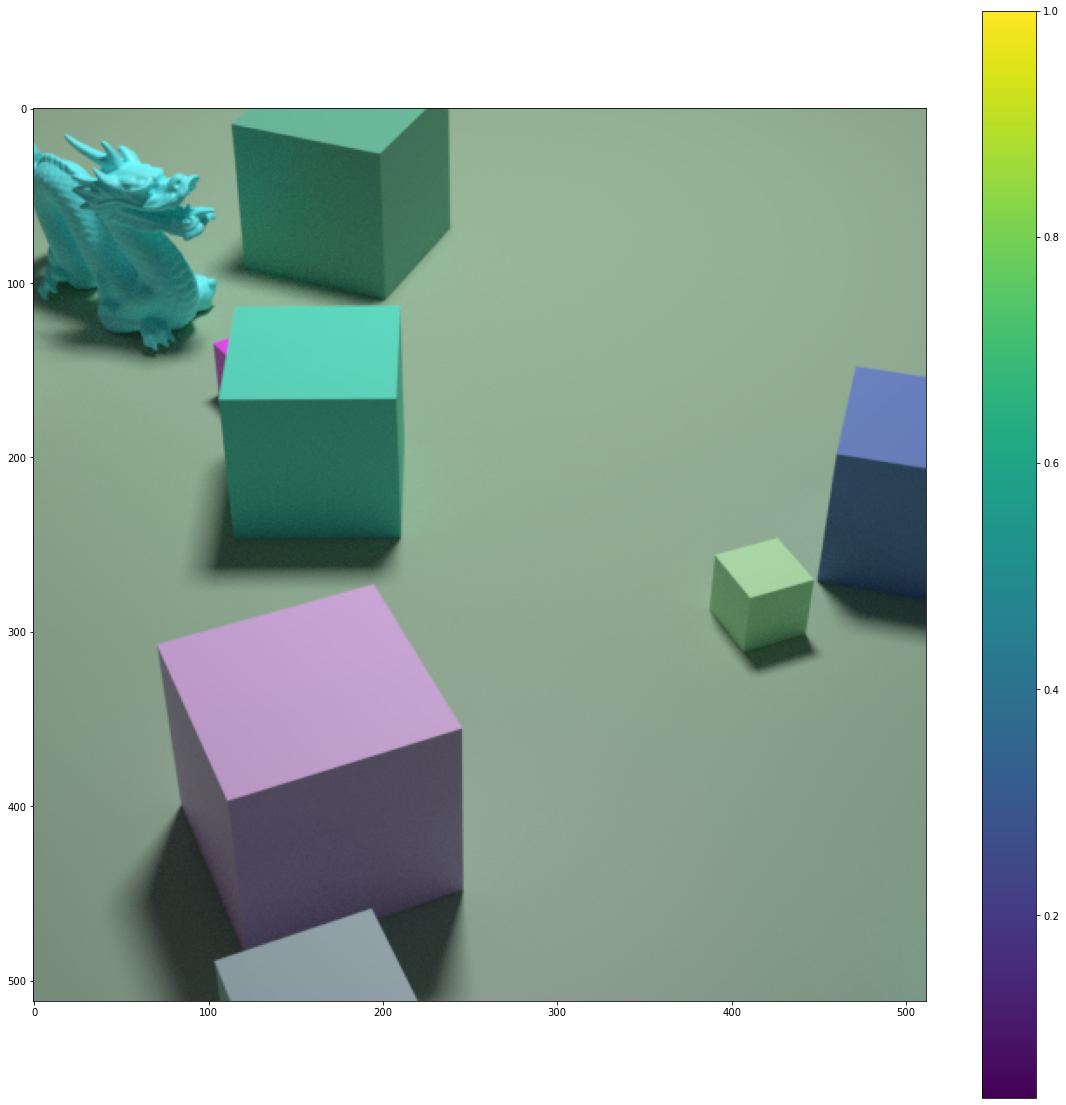

In [5]:
def EncodeToSRGB(v):
    return(np.where(v<=0.0031308,v * 12.92, 1.055*(v**(1.0/2.4)) - 0.055))

channels = []
channel_names = ['R','G','B']
exr_path = "Data/2020-10-30-Training-Data-From-OpenEXR/Image/Image0001.exr"
for channel_name in channel_names:
    channel = exr2numpy(exr_path, channel_name)
    channels.append(EncodeToSRGB(channel))
    
RGB = np.dstack(channels)
fig = plt.figure()
plt.imshow(RGB)
plt.colorbar()
plt.show()

### Creating Bounding boxes

Now we can create bounding boxes for each object in the image. Depending on what we want to do next, we could generate annotations in [COCO](
https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch
) format.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


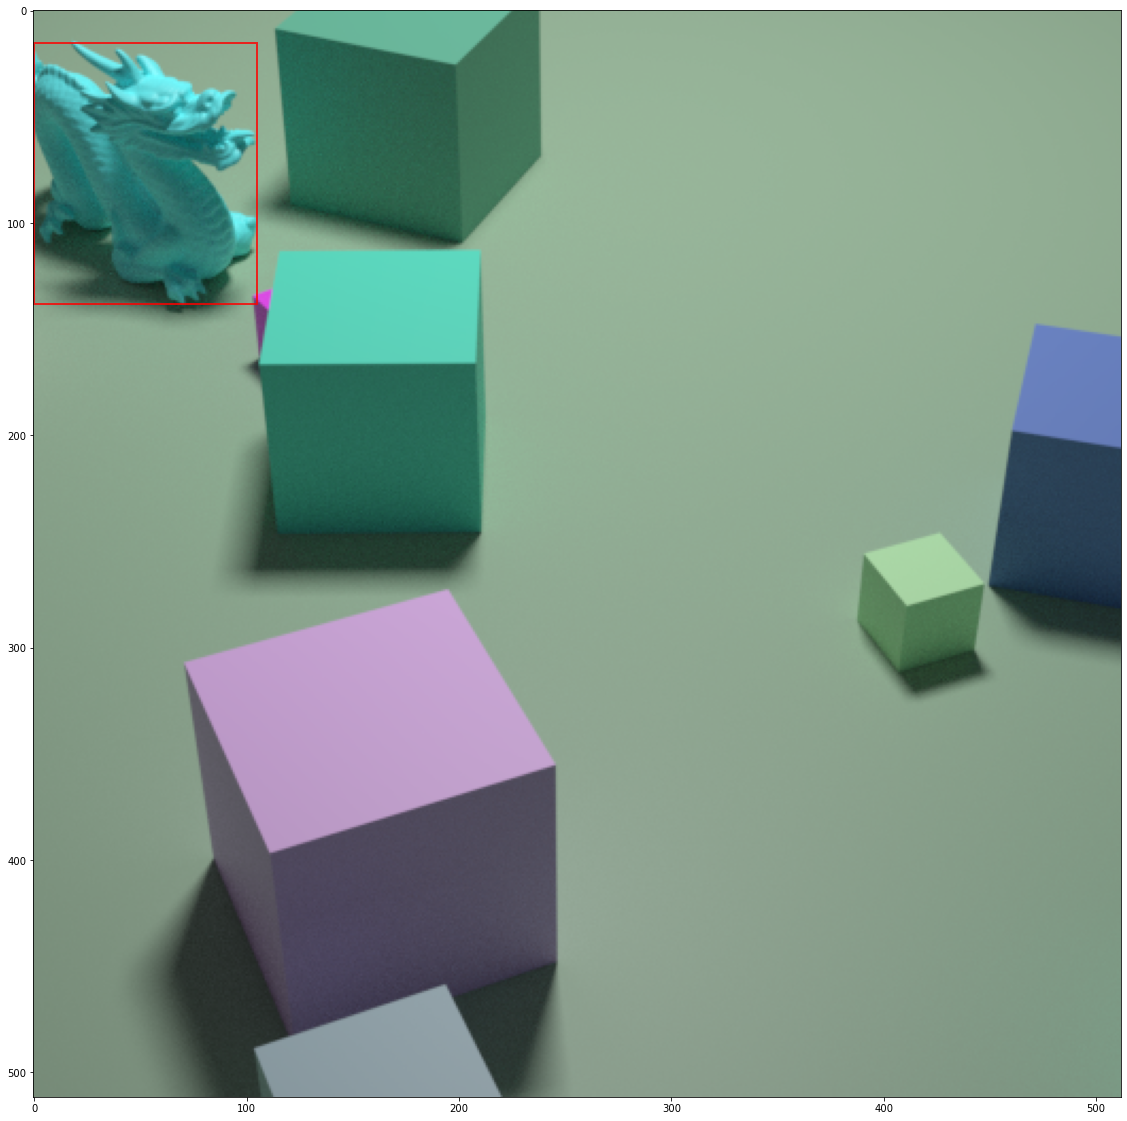

In [6]:
# Create figure and axes
fig, ax = plt.subplots(1)
# Display the image
ax.imshow(RGB)

for i in np.unique(semantic_index):
    #index 0 is the background
    if i!=0:
        #Find the location of the object mask
        yi, xi = np.where(semantic_index == i)
        
        # Create a Rectangle patch
        rect = Rectangle((np.min(xi), np.min(yi)), np.max(xi) - np.min(xi), np.max(yi) - np.min(yi), linewidth=2, edgecolor='r', facecolor='none', alpha=0.8)

        # Add the patch to the Axes
        ax.add_patch(rect)

plt.show()

### Exporting as .png

In [7]:
img = Image.fromarray(np.uint8(RGB*255))
img.save('image.png')

### Creating JSON metadata.

In [8]:
shapes = []
for i in np.unique(semantic_index):
    #index 0 is the background
    if i!=0:
        #Find the location of the object mask
        yi, xi = np.where(semantic_index == i)

        #Print the index of the object, and it's bounding box
        shapes.append({ "label": "DRAGON",
                       "points": [[int(np.min(xi)), int(np.min(yi))], [int(np.max(xi)), int(np.max(yi))]],
                       "group_id": None,
                       "shape_type": "rectangle",
                       "flags": {}})
        
        
JSON = {
    "version": "4.5.6",
    "flags": {},
    "imagePath": "image.png",
    "imageData": None,
    "imageHeight": 512,
    "imageWidth": 512
}


JSON["shapes"] = shapes

JSON = json.dumps(JSON, sort_keys=True, indent=4)

f = open('image.json','w')
f.write(JSON)
f.close()